# Mixed Linear and Non-Linear Model

Start by loading packages

In [30]:
from math import isclose, prod, sqrt
import matplotlib.pyplot as plot
import numpy as np
import random
from random import gauss, randint, uniform
from sklearn.linear_model import LinearRegression
from statistics import mean

Set constants.

Set *masterSeed* to *None* to have a 3-digit seed randomly selected for each run.  
Set it to an integer to get the sam results over and over.

Sigma represents the amount of noise added to measurements of the phenotype.

In [31]:
nGene = 4
nSamp = 100

upDownLev = 0.8

# masterSeed = 445  
masterSeed = None

sigma = 0.1

Pick or set the seed.

In [32]:
if masterSeed is not None:
	seed = masterSeed
else:
	random.seed()
	seed = randint(0, 999)
	
random.seed(seed)
print(f'Seed = {seed}')

Seed = 767


Enumerate all the possible gene combinations.  There are $2^n$ combinations.

This enumeration of all combinations is used for testing and evaluation.  This is a luxury usually 
not available in experimental settings.  In such cases sampling of the population is used for 
testing and evaluation.

*allCombNum* represents the gene combination with indicator functions (i.e., 0 or 1) and 
*allCombBool* represents the combination with booleans.  The distinction is merely to simplify 
the code.

In [33]:
nCase = 2 ** nGene
allCombNum = tuple(
	tuple((num & (1 << bNum)) >> bNum for bNum in range(nGene)) 
	for num in range (nCase))

allCombBool = list(tuple(allCombNum[i][j] == 1 for j in range(nGene)) for i in range(nCase))
allCombBool

[(False, False, False, False),
 (True, False, False, False),
 (False, True, False, False),
 (True, True, False, False),
 (False, False, True, False),
 (True, False, True, False),
 (False, True, True, False),
 (True, True, True, False),
 (False, False, False, True),
 (True, False, False, True),
 (False, True, False, True),
 (True, True, False, True),
 (False, False, True, True),
 (True, False, True, True),
 (False, True, True, True),
 (True, True, True, True)]

## Set up the problem

Assume that:
1. There is a fixed mechanism between the genotype and the phenotype.
2. That this mechanism is the combination of a linear component and second non-linear component.
3. That the non-linear component of the mechanism will either up-regulate or down-regulate when 
specific paris of genes are present. 

Don't become distracted by consideration of nature vs. nature, Lamarckian vs. Darwinian evolution,
 or epigenetics.  We have deliberately chosen a simple model because we think it illuminates 
 procedural issues.

In [34]:
linCompWeight = [uniform(-1,1) for _ in range(nGene)]
print(f'Weights of the linear component = {linCompWeight}')

Weights of the linear component = [0.6828137769936751, 0.44902049164912183, -0.785947238955746, -0.043293711395672396]


Create a function to evaluate the linear model (or a linear component of a mdoel)

In [35]:
def LinMod(weights, genes):
	assert(len(weights) == len(genes))
	result = sum((w*g for (w,g) in zip(weights,genes)))
	return result

Create a model for up and down regulation based on pairs of genes

In [36]:
def UpDownModel(geneSamp, upGroups,downGroups):
	result = 0
	for group in upGroups:
		# if g => s is true
		if all((not g) or (g and s) for (s,g) in zip(geneSamp,group)):
			result += upDownLev
	for group in downGroups:
		if all((not g) or (g and s) for (s,g)  in zip(geneSamp,group)):
			result -= upDownLev
	return result

Choose 2 gene pairs that cause up-regulation and 2 genes pairs that cause down-regulation.

In [37]:
upGroups = [(1,1,0,0), (0,0,1,1)]
downGroups = [(0,1,1,0), (1,0,0,1)]

Test *UpDownModelel*

In [38]:
result = []
for case in allCombBool:
	result.append((UpDownModel(case, upGroups,downGroups)))
result

[0, 0, 0, 0.8, 0, 0, -0.8, 0.0, 0, -0.8, 0, 0.0, 0.8, 0.0, 0.0, 0.0]

Assume that each gene occurs in the population with a fixed prevalence.  Randomly select the 
provenances of each gene.

In [39]:
prev = [uniform(0,1) for _ in range(nGene)]
print(f'Prevalence = {prev}')

Prevalence = [0.6929945607410272, 0.2945482572284368, 0.15120078518433422, 0.3462757139362944]


### Generate Samples

The random combinations of genes according to the prevalence levels assumed in the population.

In [40]:
geneSampBool = tuple(tuple(uniform(0,1) < p for p in prev) for _ in range(nSamp))
print(f'1st sample = {geneSampBool[0]}')
print(f'2nd sample = {geneSampBool[1]}')

1st sample = (False, False, False, True)
2nd sample = (True, True, False, False)


Represent the gene samples numerically (as well as logically), because sometimes it's easier to use.

In [41]:
geneSampNum = tuple(tuple(1 if hasGene else 0 for hasGene in samp) for samp in geneSampBool)
print(f'1st sample = {geneSampNum[0]}')
print(f'2nd sample = {geneSampNum[1]}')

1st sample = (0, 0, 0, 1)
2nd sample = (1, 1, 0, 0)


#### Generate Synthetic Measurements

The ground truth for the phenotype attribute to be measured will be the sum the linear model and the 
up-down regulation model.

In [42]:
truePheno = tuple(
	LinMod(linCompWeight, gn) + UpDownModel(gs,upGroups,downGroups) 
	for (gn,gs) in zip(geneSampNum,geneSampBool)
)

In [43]:
measPheno = tuple(tm + gauss(0,sigma) for tm in truePheno)
print(f'1st sample = {measPheno[0]}')
print(f'2nd sample = {measPheno[1]}')

1st sample = -0.17924649008562912
2nd sample = 1.9459178434051823


Text(0, 0.5, 'Phenotype Value')

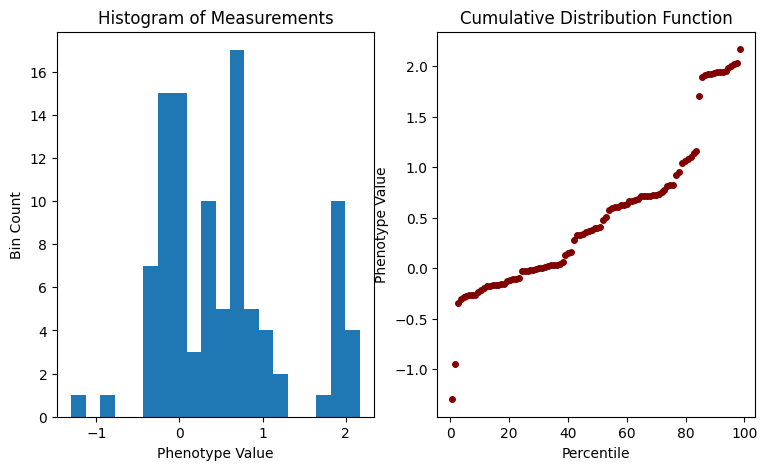

In [44]:
fig, (ax0,ax1) = plot.subplots(1,2, figsize=(9,5))

ax0.hist(measPheno, bins=20)
ax0.title.set_text('Histogram of Measurements')
ax0.set_xlabel('Phenotype Value')
ax0.set_ylabel('Bin Count')

x = [100*(k + 0.5)/(nSamp + 1) for k in range(nSamp)]
ax1.plot(x,sorted(measPheno), 'o', ms=4, c='maroon')
ax1.title.set_text('Cumulative Distribution Function')
ax1.set_xlabel('Percentile')
ax1.set_ylabel('Phenotype Value')

Notice that the variance in measurements is larger, because of the up-down regulation increases 
the spread.

### Learn Module from (i.e., Fit Model to) the Data

In [45]:
x = np.array(geneSampNum)
y = np.array(measPheno)
print(f'x shape = {x.shape}, y shape = {y.shape}')

x shape = (100, 4), y shape = (100,)


In [46]:
reg = LinearRegression()
reg.fit(x,y)

linFit = reg.coef_
print(f'Linear model fit weights:\n  {linFit}')
print(f'Ture weights for linear component:\n  {linCompWeight}')

Linear model fit weights:
  [ 0.79511275  0.90279988 -0.8128346  -0.51398018]
Ture weights for linear component:
  [0.6828137769936751, 0.44902049164912183, -0.785947238955746, -0.043293711395672396]


Notice that the estimation of the linear model is somewhat close to the linear component
of the model.  This is because the linear estimation is blind to the up-down component of the
ground truth and because the effects on the up-down model tend to average out.

Notice also that using a linear model to estimate the linear component of the linear model in
the presence of the up-down phenomena is not nearly as accurate when the up-down phenomena isn't
present.  This is because the up-down phenomena looks like noise to the linear model.

In [47]:
def RmsErrorPercent(tureL, estL):
	assert(len(tureL) == len(estL))
	
	rms = sqrt(sum(t**2 for t in tureL))
	result = sqrt(sum((e - t)**2 for (t,e) in zip(tureL,estL)) / rms)
	
	return result

In [48]:
percErr = 100*RmsErrorPercent(linFit,linCompWeight)
print(f'percent error = {percErr:.1f}%')

percent error = 53.5%


Compute the probability of every gene combination

In [49]:
prob = tuple(prod((p if g == 1 else (1 - p) for (p,g) in zip(prev,case))) for case in allCombNum)
assert(isclose(sum(prob),1))

In [50]:
def PlotColorCoded(data, upGroup,downGroup, mark='o'):
	redData = [d for d in data if (d[2] in upGroup)]
	blueData = [d for d in data if (d[2] in downGroup)]
	greenData = [d for d in data if ((d[2] not in upGroup) and (d[2] not in downGroup))]
	
	redX = [d[0] for d in redData]
	redY = [d[1] for d in redData]
	plot.plot(redX, redY, mark, c='red')
		
	blueX = [d[0] for d in blueData]
	blueY = [d[1] for d in blueData]
	plot.plot(blueX, blueY, mark, c='blue')
	
	greenX = [d[0] for d in greenData]
	greenY = [d[1] for d in greenData]
	plot.plot(greenX, greenY, mark, c='green')

Text(0, 0.5, 'Probability')

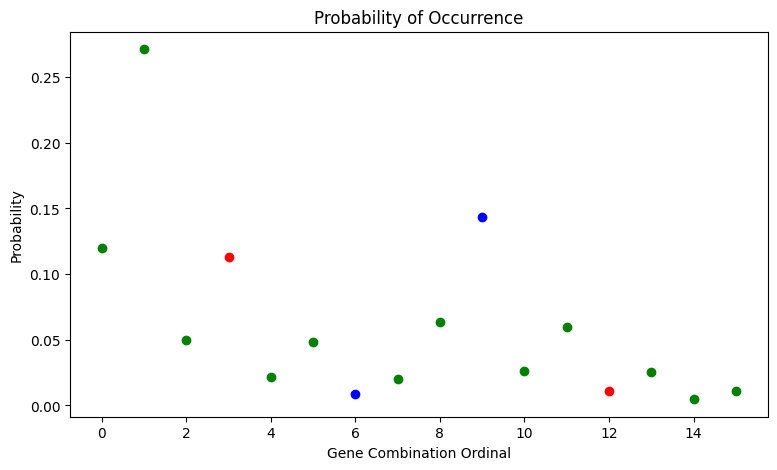

In [51]:
x = [n for n in range(nCase)]
data = list(zip(x,prob,allCombNum))

plot.subplots(figsize=(9,5))
PlotColorCoded(data, upGroups, downGroups)

plot.title('Probability of Occurrence')
plot.xlabel('Gene Combination Ordinal')
plot.ylabel('Probability')

Red markers correspond to gene combinations that yield up-regulation, the blue markers correspond
to down-regulation, and the green markers to neither.

In [52]:
linComp = tuple(LinMod(linCompWeight, case) for case in allCombNum)
linEstMeas = tuple(LinMod(linFit, case) for case in allCombNum)

The probability weighted mean RMS error

In [53]:
def RmsErrorWeight(aList,bList,weight):
	assert((len(aList) == len(bList)) and (len(bList) == len(weight)))
	totalWeight = sum(weight)
	result = sqrt(sum(w * (a-b)**2 for (a,b,w) in zip(aList,bList,weight)) / totalWeight)
	
	return result

In [54]:
rmsErr = RmsErrorWeight(linComp,linEstMeas,prob)
rmsErr

0.31255084539269906

In [55]:
sigma/rmsErr

0.31994794278785826

Here the RMS error of the difference between the linear estimation of the linear component of 
phenomena and the actual linear component of the mechanism is a few times larger (or worse) 
than the noise in the measurements.  This is because most of the error is model mismatch.

#### Plot Measurements, the Ture Linear Component, and the Learned Linear Component 

Learned is synonymous with estimated

In [56]:
def MeanByComb(sampInfo):
	result = []
	for comb in allCombNum:
		groupData = [s for s in sampInfo if (s[1] == comb)]
		if groupData: 
			result.append(mean(s[0] for s in groupData))
		else:
			result.append(None)
	return result

In [57]:
sampInfo = list(zip(measPheno, geneSampNum))
meanMeas = MeanByComb(sampInfo)

Text(0, 0.5, 'Quantity to be Measured')

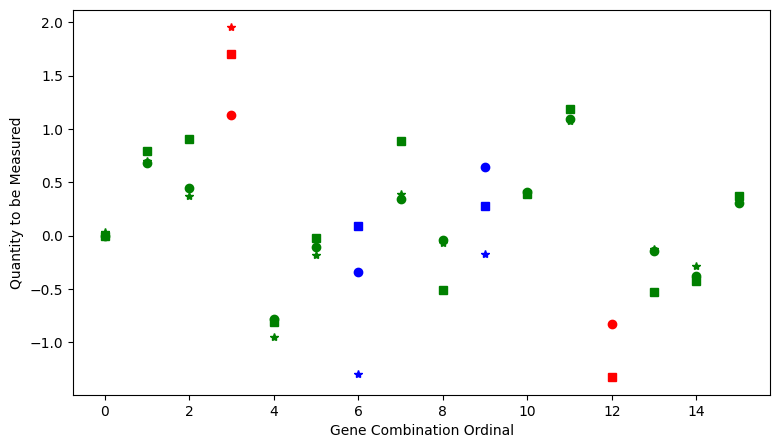

In [58]:
x = [n for n in range(nCase)]

plot.subplots(figsize=(9, 5))

sampInfo = list(zip(x, linComp, allCombNum))
PlotColorCoded(sampInfo, upGroups, downGroups)

sampInfo = list(zip(x, meanMeas, allCombNum))
PlotColorCoded(sampInfo, upGroups, downGroups, '*')

sampInfo = list(zip(x, linEstMeas, allCombNum))
PlotColorCoded(sampInfo, upGroups, downGroups, 's')

plot.xlabel('Gene Combination Ordinal')
plot.ylabel('Quantity to be Measured')

This graph shows three results for each of the 16 gene combinations:
* Circles:  represent the measurements that would occur if only the linear mechanism 
could be measured in the absence of noise.
* Starts:  show the mean of the actual measurements.
* Squares:  show the estimated component of the linear model.

Notice that starts and the circles are almost the same, except for the particular gene sequences 
where the either up regulation or down regulation occurs.  This is because, except in these 4 
cases, the linear model is the only affect on the phenotype.  For combinations where up 
regulation or down regulation occur, the measurements differ from the model by plus or minus 1.

Notice that the estiment of the linear component is pulled off the actual linear component by a 
significant amount (towards the mean measurements for these combinations) at each of the gene 
combinations that up regulate or down regulate.  This in turn distorts the estiment of the linear 
component even for gene combinations that aren't up or down regulated.

## Conclusion

The details of the notebook have shown that if the mechanism linking phenotypes to genotypes is
 a mixture of linear and non-linear mechanisms, then the "interference" of the non-linear 
 mechanism severely limits the ability to estimate the linear component (at using a linear model).
More generally, to estimate one component in a mixed model all the module components 
 must be simultaneously estimated.

But the far more significant point, not explicitly stated, is fitting with a linear model 
provides no clue to the existence of the non-linear component of the model. 